# Constrained-Capacity K-Means

## Descripción del Algoritmo

La variante Constrained-Capacity K-Means extiende el K-Means clásico considerando:

1. **Restricciones de Must-Link y Cannot-Link**  
   - Must-Link: los puntos deben asignarse al mismo cluster.  
   - Cannot-Link: los puntos no pueden estar en el mismo cluster.  

2. **Capacidad mínima y máxima por cluster**  
   - Cada cluster tiene un tamaño mínimo (capacity_min) y máximo (capacity_max).  

3. **Conflictos y resolución**  
   - Si un conjunto de must-link no cabe en un cluster cercano, se busca el siguiente cluster más cercano que cumpla la capacidad y las restricciones.  
   - Si no hay cluster posible, se marca como conflicto irresoluble y se reporta para revisión.  

## 2. Modificaciones al K-Means clásico

- **Paso de asignación modificado**:  
  - Antes de asignar un punto al cluster más cercano, verificamos:
    1. Que no se exceda la capacidad máxima del cluster.  
    2. Que no se violen restricciones de must-link y cannot-link.  
- **Paso de actualización de centroides**:  
  - Igual que K-Means clásico: cada cluster recalcula su centro como la media de los puntos asignados.  

## 3. Pseudocódigo

### Entrada:
- X: datos
- chains: listas de puntos que deben ir juntos (must-link)
- n_clusters: número de clusters
- cannot_link: lista de pares que no pueden ir juntos
- capacity_min, capacity_max: límites por cluster
- max_iter: número máximo de iteraciones por si no converge rápido el algoritmo.

### Salida:
- assignment: cluster asignado a cada punto
- centroids: centroides finales

```text
# Inicialización
Inicializar centroides aleatoriamente
Inicializar assignment de todos los puntos como -1

Para iter = 1 hasta max_iter:
    Reiniciar assignment y tamaños de cluster

    # Asignar cadenas must-link
    Para cada chain en chains:
        Ordenar clusters por distancia promedio de chain al centroide
        Para cada cluster c en orden:
            Si agregar chain excede capacity_max: continuar
            Si violar cannot-link: continuar
            Asignar todos los puntos de chain al cluster c
            Actualizar tamaño de cluster
            Romper
        Si no se pudo asignar la cadena:
            Mostrar advertencia

    # Asignar puntos solitarios
    Para cada punto p que no pertenece a ninguna chain:
        Ordenar clusters por distancia a centroide
        Para cada cluster c en orden:
            Si agregar p excede capacity_max: continuar
            Si violar cannot-link: continuar
            Asignar p al cluster c
            Actualizar tamaño de cluster
            Romper

    # Revisar clusters por debajo de capacity_min
    Para cada cluster k:
        Mientras tamaño de k < capacity_min:
            Buscar punto o cadena que se pueda mover a k
            Si no se puede mover ninguno:
                Mostrar advertencia
                Romper
            Reasignar punto o cadena
            Actualizar tamaños de clusters

    # Actualizar centroides
    Para cada cluster k:
        Calcular centroide como media de puntos asignados

# Retornar resultados
Retornar assignment y centroids
```


## Modificación del paso de asignación cuando un cluster alcanza su capacidad

- Antes de asignar un punto o una cadena must-link a un cluster, el algoritmo verifica:
  - Si agregar el punto/cadena excede la capacidad máxima del cluster.  
  - Si excede, se ignora ese cluster y se prueba el siguiente cluster más cercano.
- Esto asegura que ningún cluster supere su capacidad máxima durante la asignación inicial.

## 2. Garantía de cumplimiento de las restricciones must-link y cannot-link

- **Must-Link:**  
  - Todos los puntos de una cadena must-link se asignan juntos como un bloque.  
  - La asignación se realiza solo si todo el bloque puede entrar en un cluster sin exceder la capacidad máxima y sin violar cannot-link.
  
- **Cannot-Link:**  
  - Antes de asignar un punto o cadena a un cluster, se revisa que ningún punto ya asignado al cluster tenga un conflicto en cannot_link.  
  - Si hay conflicto, se descarta ese cluster y se prueba el siguiente más cercano.

## 3. Manejo de conflictos irresolubles

- Estrategia del algoritmo:
  1. Intentar asignar la cadena al siguiente cluster más cercano que cumpla capacidad y restricciones.  
  2. Si ningún cluster puede acomodar toda la cadena, se imprime una advertencia indicando que la cadena no se pudo asignar.
- De manera similar, si un cluster queda por debajo de su capacidad mínima y no hay puntos o cadenas que se puedan mover sin violar restricciones, se imprime una advertencia de conflicto irresoluble.




In [39]:
"""
En must link se puede dar el caso de que haya dependencias, por ejemplo 
(a,b), (b,c), (c,d) lo cual nos da lugar a que deben de estar conectados
(a,b,c,d), como si fueran una cadena. Cada cadena tendra un inicio que será 
el punto representante de esa cadena.
"""
def find_chains(must_link):
    # Extraemos todos los puntos involucrados
    points = set([x for pair in must_link for x in pair])
    
    # Inicialmente cada punto es su propio representante
    representative = {x: x for x in points}
    
    # Encuentra al representante de la cadena a la que pertenese x
    def find_representative(x):
        while representative[x] != x:
            representative[x] = representative[representative[x]]  
            x = representative[x]
        return x
    
    def union(x, y):
        representative[find_representative(x)] = find_representative(y)
    
    for a, b in must_link:
        union(a, b)
    
    # Construimos las cadenas
    chains_dict = {}
    for x in points:
        rep = find_representative(x)
        if rep not in chains_dict:
            chains_dict[rep] = []
        chains_dict[rep].append(x)
    
    # Devolvemos el conjunto de todas las cadenas independientes.
    return set(tuple(sorted(chain)) for chain in chains_dict.values())



In [40]:
import numpy as np

def cc_kmeans(X, chains, n_clusters, cannot_link, capacity_min, capacity_max, max_iter=50):
 
    n_points = X.shape[0]

    # Identificar puntos solitarios y los que están en cadenas
    all_points = set(range(n_points))
    points_in_chains = set(p for chain in chains for p in chain)
    solo_points = list(all_points - points_in_chains)

    # Inicializar centroides aleatoriamente
    centroids = X[np.random.choice(n_points, n_clusters, replace=False)]

    # Asignación inicial: -1 significa sin asignar
    assignment = np.full(n_points, -1)
    clusters_sizes = [0] * n_clusters

    # Para búsqueda rápida
    cannot_link_set = set(cannot_link)

    # Mapeo de punto -> cadena must-link
    point_to_chain = {}
    for chain in chains:
        for p in chain:
            point_to_chain[p] = chain

    for iteration in range(max_iter):
        # Reiniciamos asignaciones y tamaños
        assignment[:] = -1
        clusters_sizes = [0] * n_clusters

        # Asignamos las cadenas must_link
        for chain in chains:
            distances = [np.mean([np.linalg.norm(X[p]-centroids[k]) for p in chain])
                         for k in range(n_clusters)]
            sorted_clusters = np.argsort(distances)

            assigned = False
            for c in sorted_clusters:
                if clusters_sizes[c] + len(chain) > capacity_max:
                    continue

                # Verificar cannot-link
                conflict = False
                for p in chain:
                    for q in range(n_points):
                        if assignment[q] == c and ((p,q) in cannot_link_set or (q,p) in cannot_link_set):
                            conflict = True
                            break
                    if conflict:
                        break

                if conflict:
                    continue

                # Asignar la cadena
                for p in chain:
                    assignment[p] = c
                clusters_sizes[c] += len(chain)
                assigned = True
                break

            if not assigned:
                print(f"Advertencia: cadena {chain} no se pudo asignar a ningún cluster.")

        # Asignamos puntos solitarios que no pertenecen a una cadena
        for p in solo_points:
            distances = [np.linalg.norm(X[p]-centroids[k]) for k in range(n_clusters)]
            sorted_clusters = np.argsort(distances)

            for c in sorted_clusters:
                if clusters_sizes[c] + 1 > capacity_max:
                    continue

                conflict = False
                for q in range(n_points):
                    if assignment[q] == c and ((p,q) in cannot_link_set or (q,p) in cannot_link_set):
                        conflict = True
                        break
                if conflict:
                    continue

                assignment[p] = c
                clusters_sizes[c] += 1
                break

        # Damos una pasada por cada cluster para ver si esta por debajo de su capacidad.
        for k in range(n_clusters):
            while clusters_sizes[k] < capacity_min:
                moved = False
                for q in range(n_points):
                    current_cluster = assignment[q]

                    # No mover puntos que ya están en cluster k
                    if current_cluster == k:
                        continue

                    # Identificar la cadena completa si pertenece a una
                    chain_to_move = point_to_chain.get(q, [q])

                    # Verificar capacidad máxima del cluster destino
                    if clusters_sizes[k] + len(chain_to_move) > capacity_max:
                        continue

                    # Verificar cannot-link
                    conflict = False
                    for p in chain_to_move:
                        for r in range(n_points):
                            if assignment[r] == k and ((p,r) in cannot_link_set or (r,p) in cannot_link_set):
                                conflict = True
                                break
                        if conflict:
                            break
                    if conflict:
                        continue

                    # Verificar que al mover la cadena el cluster original no caiga por debajo de capacity_min
                    original_cluster_size = clusters_sizes[current_cluster]
                    if original_cluster_size - len(chain_to_move) < capacity_min:
                        continue

                    # Reasignar cadena/punto
                    for p in chain_to_move:
                        clusters_sizes[assignment[p]] -= 1
                        assignment[p] = k
                        clusters_sizes[k] += 1
                    moved = True
                    break

                if not moved:
                    print(f"Advertencia: no se pudo cumplir capacity_min para el cluster {k}")
                    break

        # Actualizamos los centroides
        for k in range(n_clusters):
            points_in_cluster = np.where(assignment==k)[0]
            if len(points_in_cluster) > 0:
                centroids[k] = X[points_in_cluster].mean(axis=0)

    return assignment, centroids

In [41]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Fijamos la semilla para reproducibilidad.
np.random.seed(42)

# Creamos nuestros datos sintéticos
n_points = 1000
n_clusters = 5 # número de clusters
X, y_true = make_blobs(n_samples=n_points, centers=n_clusters, cluster_std=[1.0, 2.5, 0.5, 3.0, 1.5], random_state=42)

# Restricciones aleatorias
must_link = [(np.random.randint(0, n_points), np.random.randint(0, n_points)) for _ in range(20)]
cannot_link = [(np.random.randint(0, n_points), np.random.randint(0, n_points)) for _ in range(30)]

capacity_min = 150
capacity_max = 250

chains = find_chains(must_link)

assignment_cc, centroids_cc = cc_kmeans(X, chains, n_clusters, cannot_link, capacity_min, capacity_max)

# Calculamos kmeans clásico
kmeans_std = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
centroids_std = kmeans_std.cluster_centers_
assignment_std = kmeans_std.labels_

# Imprimos el tamaño de cada cluster.
print("CC-KMeans sizes:", [np.sum(assignment_cc==k) for k in range(n_clusters)])
print("Standard KMeans sizes:", [np.sum(assignment_std==k) for k in range(n_clusters)])


CC-KMeans sizes: [np.int64(155), np.int64(250), np.int64(203), np.int64(238), np.int64(154)]
Standard KMeans sizes: [np.int64(203), np.int64(258), np.int64(155), np.int64(141), np.int64(243)]


Vemos que si se cumple las condiciones que les pusimos a cada cluster, en el de restricciones todos estan entre 150 y 250. Ahora vamos a comparar la distancia intracluster promedio de todos los puntos, la intuición dice que la de restricciones debe de ser mas alta.

In [42]:
def mean_intra_cluster_distance(X, assignment, centroids):
    """
    Calcula la distancia promedio de todos los puntos a su centroide asignado.
    """
    distances = np.linalg.norm(X - centroids[assignment], axis=1)
    return np.mean(distances)

dist_cc = mean_intra_cluster_distance(X, assignment_cc, centroids_cc)
dist_std = mean_intra_cluster_distance(X, assignment_std, centroids_std)

print(f"CC-KMeans distancia media intra-cluster: {dist_cc}")
print(f"K-Means estándar distancia media intra-cluster: {dist_std}")


CC-KMeans distancia media intra-cluster: 2.036246785836869
K-Means estándar distancia media intra-cluster: 1.8963954980714566


Vemos que el kmeans con las restricciones tiene una peor distancia intracluster pero no esta tan alejada de la de kmeans. Vamos a visualizar los clusters de cada algoritmo.

/tmp/ipykernel_3067585/1279653260.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_clusters)


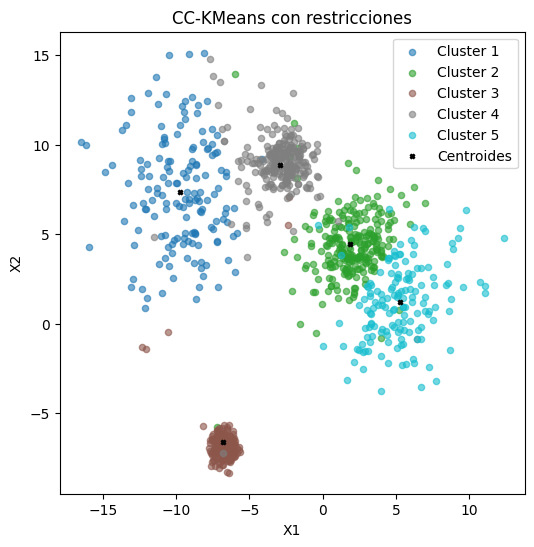

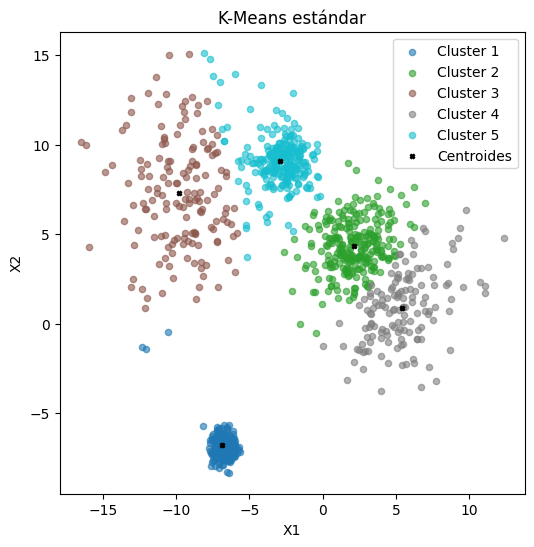

In [43]:
import matplotlib.pyplot as plt

def plot_clusters(X, assignment, centroids, title):
    n_clusters = centroids.shape[0]
    plt.figure(figsize=(6,6))
    
    # Colores para cada cluster
    colors = plt.cm.get_cmap("tab10", n_clusters)
    
    for k in range(n_clusters):
        points = X[assignment == k]
        plt.scatter(points[:,0], points[:,1], s=20, color=colors(k), alpha=0.6, label=f"Cluster {k + 1}")
    
    # Centroides
    plt.scatter(centroids[:,0], centroids[:,1], s=10, color="black", marker="X", label="Centroides")
    
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()


plot_clusters(X, assignment_cc, centroids_cc, "CC-KMeans con restricciones")
plot_clusters(X, assignment_std, centroids_std, "K-Means estándar")


Vemos que en el kmeans modificado asigna puntos a clusters muy alejados, es por las mismas restricciones que pasa esto, pero en general está bastante bien.